In [1]:
%matplotlib inline
import numpy as np                   # math
import pandas as pd                  # manipulating data
import matplotlib.pyplot as plt      # graphing
import os                            # useful for handling filenames etc.

# calculates the Pearson correlation coefficient, p-value, and does linear regression
from scipy.stats import pearsonr, linregress

from datetime import datetime, date  # working with date and time
import seaborn as sns                # makes matplotlib beautiful
sns.set_style('darkgrid')

import matplotlib as mpl             # control formatting
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.titleweight'] = 'semibold'

# interactive graphs
from bokeh.io import output_notebook, show, push_notebook
from bokeh.plotting import figure
from bokeh.layouts import row, column
from bokeh.models import DatetimeTickFormatter
output_notebook()

# manage date and time
from datetime import datetime, timedelta, date

Loading BokehJS ...

Let's try to see if Pandas can read the `.csv` files coming from Weather Underground.

In [2]:
CSV_URL = 'https://www.wunderground.com/weatherstation/WXDailyHistory.asp?\
ID=KCABERKE22&day=24&month=06&year=2018&graphspan=day&format=1'
df = pd.read_csv(CSV_URL, index_col=False)
df

,Time,TemperatureF,DewpointF,PressureIn,WindDirection,WindDirectionDegrees,WindSpeedMPH,WindSpeedGustMPH,Humidity,HourlyPrecipIn,Conditions,Clouds,dailyrainin,SolarRadiationWatts/m^2,SoftwareType,DateUTC<br>
0,2018-06-24 00:00:18,63.3,52.2,29.70,WNW,293.0,0.0,0.0,67.0,0.0,NaN,NaN,0.0,0.0,Wunderground v.1.15,2018-06-24 07:00:18
1,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-06-24 00:10:01,62.7,52.0,29.70,WNW,293.0,0.0,0.0,68.0,0.0,NaN,NaN,0.0,0.0,Wunderground v.1.15,2018-06-24 07:10:01
3,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-06-24 00:15:13,62.2,52.3,29.70,WNW,293.0,0.0,0.0,70.0,0.0,NaN,NaN,0.0,0.0,Wunderground v.1.15,2018-06-24 07:15:13
5,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2018-06-24 00:25:05,61.3,52.2,29.70,WNW,293.0,0.0,0.0,72.0,0.0,NaN,NaN,0.0,0.0,Wunderground v.1.15,2018-06-24 07:25:05
7,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2018-06-24 00:30:01,60.9,52.2,29.70,WNW,293.0,0.0,0.0,73.0,0.0,NaN,NaN,0.0,0.0,Wunderground v.1.15,2018-06-24 07:30:01
9,<br>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# remove every other row from the data because they contain `<br>` only
dg = df.drop([2*i + 1 for i in range(236)])
dg

In [ ]:
def get_clean_df(location_id, date):
    """Get weather data from `location_id` on `date`, then
    remove all the `<br>` tags in the file.
    
    `date` should be a list/tuple of 3 strings in the format
    [MM, DD, YYYY].
    """
    url = f'''\
https://www.wunderground.com/weatherstation/WXDailyHistory.asp?\
ID={location_id}&\
day={date[1]}&\
month={date[0]}&\
year={date[2]}&\
graphspan=day&\
format=1'''
#     print(f'Getting data from {url}')
    data = pd.read_csv(url, index_col=False)
    # drop every other row because it contains `<br>`
    return data.drop([2*i + 1 for i in range(data.shape[0] // 2)])

# ws_data = get_clean_df('KCABERKE105', ['05', '06', '2018'])  # weather station data

Now that we have a way of getting weather station data, let's do some time-based binning! But first, we will have to do a few things to make this data compatible with our sensor data. We will 
* convert the times into timestamps,
* convert temperatures to degrees Celsius

In [ ]:
def process_data(data_df):
    def deg_f_to_c(deg_f):
        return (5 / 9) * (deg_f - 32)

    def inhg_to_mbar(inhg):
        return 33.863753 * inhg

    for idx, time, tempf, dewf, pressure, *_ in data_df.itertuples():
        data_df.loc[idx, 'Time'] = datetime.strptime(time, '%Y-%m-%d %H:%M:%S').timestamp()
        data_df.loc[idx, 'Temperature'] = deg_f_to_c(tempf)
        data_df.loc[idx, 'Dewpoint'] = deg_f_to_c(dewf)
        data_df.loc[idx, 'Pressure'] = inhg_to_mbar(pressure)

    return data_df.drop(['TemperatureF', 'DewpointF', 'PressureIn', 'WindDirection', 'Conditions', 'Clouds',
#                          'SolarRadiationWatts/m^2', 
                         'SoftwareType', 'DateUTC<br>'], axis=1)

process_data(get_clean_df('KCABERKE105', ['05', '06', '2018']))

In [ ]:
DATA_DIR = 'binned_data'

temperature_data = pd.read_csv(os.path.join(DATA_DIR, 'data_temperature_2400.csv'),
                               header=0, names=['unix_time', 'temperature'])

for idx, timestamp, temp in temperature_data.itertuples():
    temperature_data.loc[idx, 'datetime'] = datetime.fromtimestamp(timestamp)

temperature_data[26230:]

From the previous cell, we see that temperature data (and for that matter, all other sensor data) begins from 17 November, 2017. So we only need to get weather station data from that date on.

In [ ]:
start_time = date.fromtimestamp(int(temperature_data.loc[26230, 'unix_time']))
end_time = date.fromtimestamp(int(temperature_data.loc[temperature_data.shape[0] - 1, 'unix_time']))

current_time = start_time
data_df = pd.DataFrame([])
while current_time < end_time:
    # store the result of the query in dataframe `data_df`
    temporary = process_data(get_clean_df('KCABERKE105', [str(current_time.month),
                                                          str(current_time.day),
                                                          str(current_time.year)]))
    temp_cols = list(temporary.columns.values)
    temporary = temporary[[temp_cols[6]] + temp_cols[:6] + temp_cols[7:]]
    data_df = pd.concat([data_df, temporary], ignore_index=True)
    current_time = current_time + timedelta(days=1)

data_df

In [ ]:
# data_df.rename({'Time': 'deviceTime_unix'}, axis=1, inplace=True)
data_df.to_csv('wunderground_data/data_0.csv', na_rep='nan', index=False)

## Comparing Weather Stations to our Weather Data
Now let's look at the *differences* between the average temperatures measured by the weather station versus our measurements. We chose a weather station close to Etcheverry Hall, so the measurements should be about the same. If the difference is relatively constant but nonzero, that is fine. That would correspond to calibration errors in our sensors (or the weather stations'!), but they should be correlated, and subtraction by a constant does not change correlations, so we would be confident that our correlations with temperature, pressure and humidity with radiation are meaningful.

First, let's try to use data averaged over half a day (43200 seconds). The best way to do look for both correlation and differences together is to plot the linear regression. We will see a straight line in the data if there is high correlation, and the slope of the line will be close to 1 if the data are the same.

In [73]:
def weather_station_diff_and_corr(interval):
    ws_temp = pd.read_csv(f'binned_data/ws_data_Temperature_{interval}.csv',
                           header=0, names=['utime', 'temp'], usecols=[1])
    ws_pressure = pd.read_csv(f'binned_data/ws_data_Pressure_{interval}.csv',
                               header=0, names=['utime', 'pressure'], usecols=[1])
    ws_humidity = pd.read_csv(f'binned_data/ws_data_Humidity_{interval}.csv',
                               header=0, names=['utime', 'humid'], usecols=[1])
    
    our_temp = pd.read_csv(f'binned_data/data_temperature_{interval}.csv',
                            header=0, names=['utime', 'ws_temp'], usecols=[1])
    our_pressure = pd.read_csv(f'binned_data/data_pressure_{interval}.csv',
                                header=0, names=['utime', 'ws_pressure'], usecols=[1])
    our_humidity = pd.read_csv(f'binned_data/data_humidity_{interval}.csv',
                                header=0, names=['utime', 'ws_humid'], usecols=[1])
    
    temps = pd.concat([ws_temp, our_temp], axis=1).dropna(axis=0)
    pressures = pd.concat([ws_pressure, our_pressure], axis=1).dropna(axis=0)
    humids = pd.concat([ws_humidity, our_humidity], axis=1).dropna(axis=0)
    
    # temperature plot
    g1 = sns.jointplot(x='temp', y='ws_temp', data=temps, kind='reg')
    plt.xlabel('Our Temperature ($^oC$)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Temperature ($^oC$)', rotation=90, fontdict={'fontsize': 12})
    g1.fig.suptitle('Temperature', fontsize=16, fontweight='semibold',
                   x=0.4, y=1.03)
    
    # presssure plot
    g2 = sns.jointplot(x='pressure', y='ws_pressure', data=pressures, kind='reg')
    plt.xlabel('Our Pressure (millibars)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Pressure (millibars)', rotation=90, fontdict={'fontsize': 12})
    g2.fig.suptitle('Pressure', fontsize=16, fontweight='semibold',
                   x=0.4, y=1.03)

    # humidity plot
    g3 = sns.jointplot(x='humid', y='ws_humid', data=humids, kind='reg')
    plt.xlabel('Our Humidity (percentage)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Humidity (percentage)', rotation=90, fontdict={'fontsize': 12})
    g3.fig.suptitle('Humidity', fontsize=14, fontweight='semibold',
                   x=0.4, y=1.03)
    
    return temps, pressures, humids

/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has bee

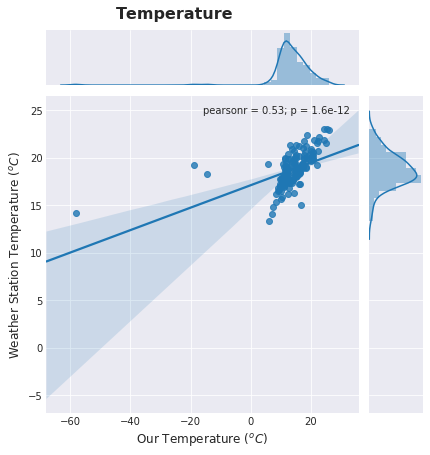

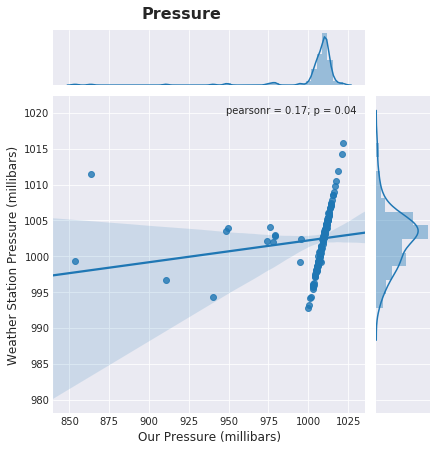

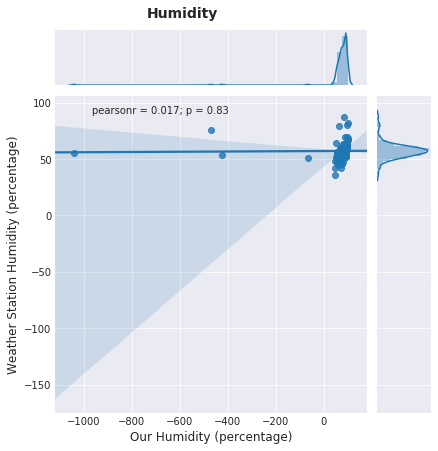

In [74]:
t, h, p = weather_station_diff_and_corr(43200)

Uggh! There are a few influential points that should not exist. Let's get rid of them too in `weather_station_diff_and_corr`.

In [122]:
def remove_influential_pts(df: pd.DataFrame, z_star: float):
    if df.shape[1] != 2:
        raise ValueError('DataFrame must have shape `Nx2`')
    
    for idx, elem1, elem2 in df.itertuples():
        if (abs((elem1 - df.iloc[:, 0].mean()) / df.iloc[:, 0].std()) > z_star or
            abs((elem2 - df.iloc[:, 1].mean()) / df.iloc[:, 1].std()) > z_star):
            df.loc[idx] = float('nan')
    
    return df.dropna()


def weather_station_diff_and_corr(interval):
    ws_temp = pd.read_csv(f'binned_data/ws_data_Temperature_{interval}.csv',
                           header=0, names=['utime', 'temp'], usecols=[1])
    ws_pressure = pd.read_csv(f'binned_data/ws_data_Pressure_{interval}.csv',
                               header=0, names=['utime', 'pressure'], usecols=[1])
    ws_humidity = pd.read_csv(f'binned_data/ws_data_Humidity_{interval}.csv',
                               header=0, names=['utime', 'humid'], usecols=[1])
    
    our_temp = pd.read_csv(f'binned_data/data_temperature_{interval}.csv',
                            header=0, names=['utime', 'ws_temp'], usecols=[1])
    our_pressure = pd.read_csv(f'binned_data/data_pressure_{interval}.csv',
                                header=0, names=['utime', 'ws_pressure'], usecols=[1])
    our_humidity = pd.read_csv(f'binned_data/data_humidity_{interval}.csv',
                                header=0, names=['utime', 'ws_humid'], usecols=[1])
    
    temps = pd.concat([ws_temp, our_temp], axis=1).dropna(axis=0)
    pressures = pd.concat([ws_pressure, our_pressure], axis=1).dropna(axis=0)
    humids = pd.concat([ws_humidity, our_humidity], axis=1).dropna(axis=0)
    
    temps = remove_influential_pts(temps, 2.5)
    pressures = remove_influential_pts(pressures, 1.4)
    humids = remove_influential_pts(humids, 4.)
    
    # temperature plot
    g1 = sns.jointplot(x='temp', y='ws_temp', data=temps, kind='reg')
    m1, b1 = linregress(temps['temp'], temps['ws_temp'])[0:2]
    plt.xlabel('Our Temperature ($^oC$)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Temperature ($^oC$)', rotation=90, fontdict={'fontsize': 12})
    g1.fig.suptitle(f'Temperature (${m1:.2f}x+{b1:.2f}$)', fontsize=16, fontweight='semibold',
                   x=0.4, y=1.03)
    
    # presssure plot
    g2 = sns.jointplot(x='pressure', y='ws_pressure', data=pressures, kind='reg')
    m2, b2 = linregress(pressures['pressure'], pressures['ws_pressure'])[0:2]
    plt.xlabel('Our Pressure (millibars)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Pressure (millibars)', rotation=90, fontdict={'fontsize': 12})
    g2.fig.suptitle(f'Pressure (${m2:.2f}x+{b2:.2f}$)', fontsize=16, fontweight='semibold',
                   x=0.4, y=1.03)

    # humidity plot
    g3 = sns.jointplot(x='humid', y='ws_humid', data=humids, kind='reg')
    m3, b3 = linregress(humids['humid'], humids['ws_humid'])[0:2]
    plt.xlabel('Our Humidity (percentage)', fontdict={'fontsize': 12})
    plt.ylabel('Weather Station Humidity (percentage)', rotation=90, fontdict={'fontsize': 12})
    g3.fig.suptitle(f'Humidity (${m3:.2f}x+{b3:.2f}$)', fontsize=14, fontweight='semibold',
                   x=0.4, y=1.03)
    
    return temps, pressures, humids

/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has bee

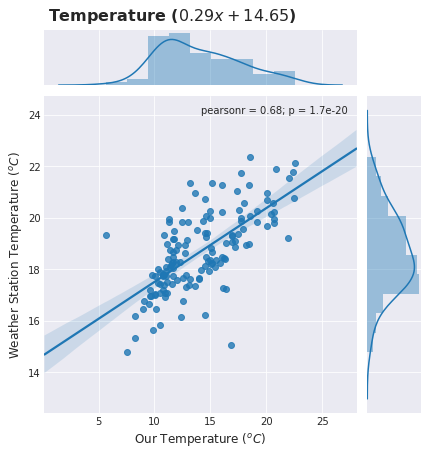

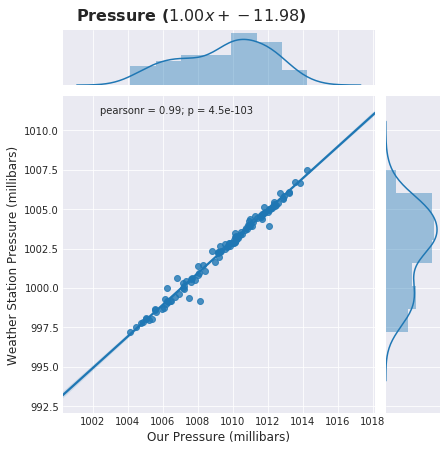

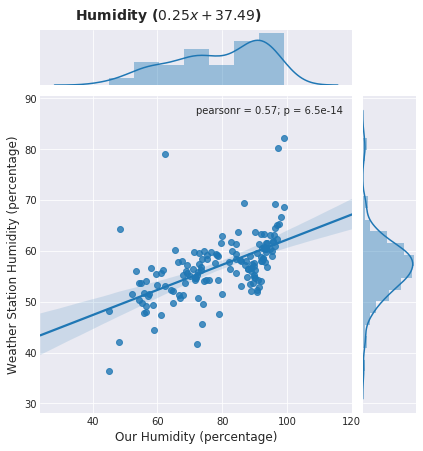

In [123]:
t, p, h = weather_station_diff_and_corr(43200)

/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/sagnick/.conda/envs/jetcar/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has bee

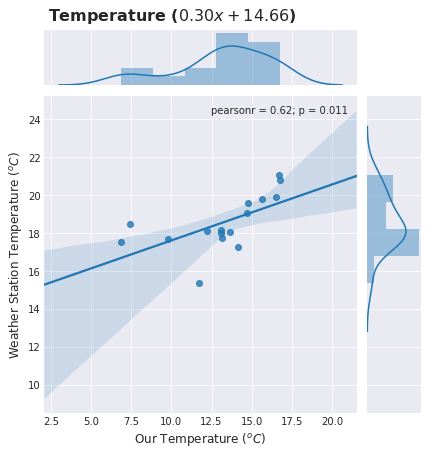

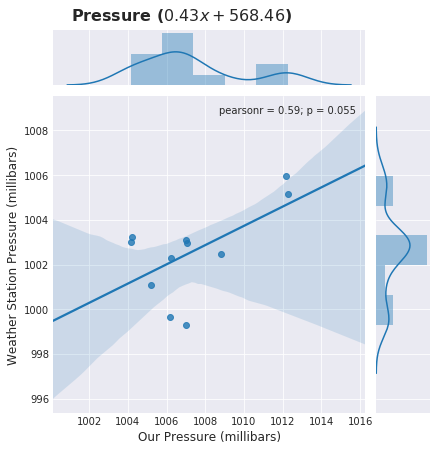

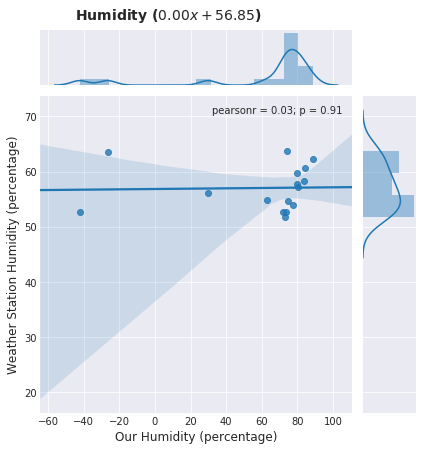

In [124]:
t, p, h = weather_station_diff_and_corr(432000)